In [2]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install livelossplot

**Main imports**

In [5]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [10]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=True, batch_size=16, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
shuffle=False, batch_size=16, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

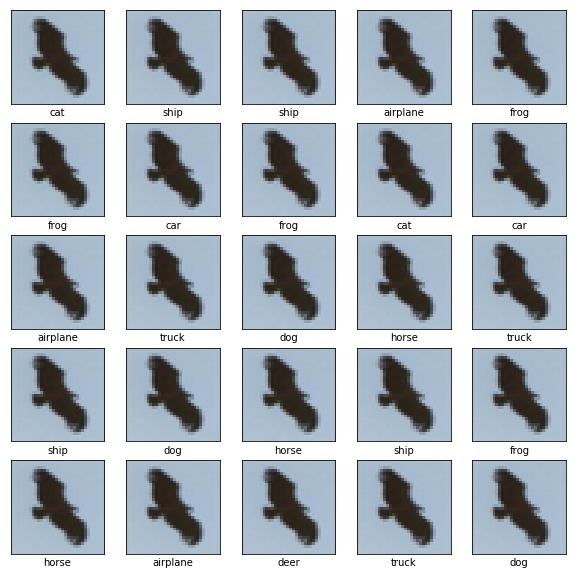

In [59]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define a simple model**

In [76]:
# define variational autoencoder components along with a discriminator models
class Encoder(nn.Module):
    def __init__(self, intermediate_size=128, hidden_size=20):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(3, 32, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 32, intermediate_size)

        self.fc21 = nn.Linear(intermediate_size, hidden_size)
        self.fc22 = nn.Linear(intermediate_size, hidden_size)

    def encode(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        h1  = F.relu(self.fc1(out))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, intermediate_size=128, hidden_size=20):
        super(Decoder, self).__init__()

        self.fc3 = nn.Linear(hidden_size, intermediate_size)
        self.fc4 = nn.Linear(intermediate_size, 8192)
        self.deconv1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0)
        self.conv5 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    def decode(self, z):
        h3  = F.relu(self.fc3(z))
        out = F.relu(self.fc4(h3))
        out = out.view(out.size(0), 32, 16, 16)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        out = torch.sigmoid(self.conv5(out))
        return out

    def forward(self, z):
        return self.decode(z)

class ResidualBlock(nn.Module):
   def __init__(self, in_features):
       super(ResidualBlock, self).__init__()

       conv_block = [ nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
                      nn.BatchNorm2d(in_features),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
                      nn.BatchNorm2d(in_features) ]

       self.conv_block = nn.Sequential(*conv_block)

   def forward(self, x):
       return x + self.conv_block(x)

class Discriminator(nn.Module):
    def __init__(self, f=64):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            nn.Conv2d(3, f, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f, f*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f*2, f*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f*4, f*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f*8, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

N_Encoder = Encoder().to(device)
N_Decoder = Decoder().to(device)
N_Discriminator = Discriminator().to(device)
ENCODER_MODEL_PATH = 'encoder_model.pkl'
DECODER_MODEL_PATH = 'decoder_model.pkl'
DISCRIMINATOR_MODEL_PATH = 'discriminator_model.pkl'

try:
    N_Encoder.load_state_dict(torch.load(ENCODER_MODEL_PATH, map_location='cpu'))
    N_Encoder.eval()
    N_Decoder.load_state_dict(torch.load(DECODER_MODEL_PATH, map_location='cpu'))
    N_Decoder.eval()
    N_Discriminator.load_state_dict(torch.load(DISCRIMINATOR_MODEL_PATH, map_location='cpu'))
    N_Discriminator.eval()
except:
    print('no model found')

optimiser_encoder = torch.optim.Adam(N_Encoder.parameters(), lr=0.001)
optimiser_decoder = torch.optim.Adam(N_Decoder.parameters(), lr=0.001)
optimiser_discriminator = torch.optim.Adam(N_Discriminator.parameters(), lr=0.001)

bce_loss = nn.BCELoss()

**Main training loop**

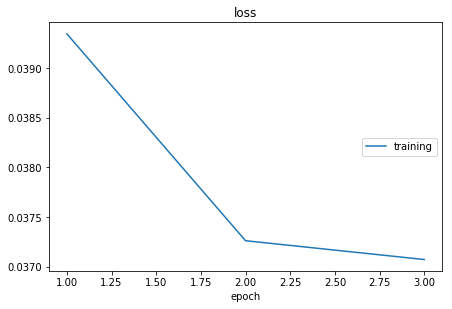

loss:
training   (min:    0.037, max:    0.039, cur:    0.037)


KeyboardInterrupt: 

In [13]:
# training loop, feel free to also train on the test dataset if you like for generating the pegasus
while (epoch<10):
    
    # arrays for metrics
    logs = {}
    train_loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        loss = ((p-x)**2).mean() # simple l2 loss
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)

    # NOTE: live plot library has dumb naming forcing our 'test' to be called 'validation'
    liveplot.update({
        'loss': train_loss_arr.mean()
    })
    liveplot.draw()

    epoch = epoch+1

**Generate a Pegasus by interpolating between the latent space encodings of a horse and a bird**

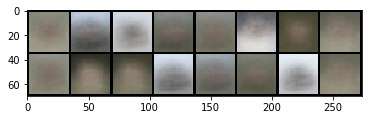

In [57]:
# show some inputs
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

# show some predictions
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(p).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

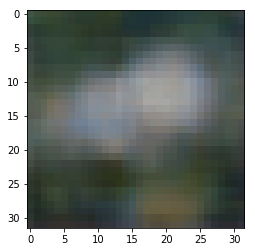

In [75]:
example_1 = (test_loader.dataset[13][0]).to(device)  # horse
example_2 = (test_loader.dataset[160][0]).to(device) # bird

ex1_z, ex1_mu, ex1_logvar = N_Encoder(example_1.unsqueeze(0))
ex2_z, ex2_mu, ex2_logvar = N_Encoder(example_2.unsqueeze(0))

# this is some sad blurry excuse of a Pegasus, hopefully you can make a better one
bad_pegasus = N_Decoder(0.9*ex1_z + 0.1*ex2_z).squeeze(0)

pegasus = bad_pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0)

plt.grid(False)
plt.imshow(bad_pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

#for i in range(len(test_loader.dataset.test_labels)):
#  print(class_names[test_loader.dataset.test_labels[i]] + '\t idx: ' + str(i))

In [41]:
np.random.rand(3, 512, 256).T.shape

(256, 512, 3)